# Lasso 

In [4]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.3.0)
  CPU: 10 × Apple M1 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores


In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

In [2]:
# load packages
using BenchmarkTools, DelimitedFiles, DataFrames, Distributions, DynamicHMC, DynamicHMC, 
    LinearAlgebra, LogDensityProblems, MCMCChains, 
    Parameters, Profile, ProximalOperators,
    Random, Revise, Roots, SparseArrays, Statistics, StatsPlots, RCall
import ProximalOperators: prox, prox!
gr(size=(1600, 1200))

Plots.GRBackend()

In [3]:
"""
    ϕ(x::Vector, λ)

Return the value `sum(abs, Sλ(x[1:end-1])) - λ - x[end]`.
"""
function ϕ(x::AbstractVector{T}, λ::T) where T <: Real
    out = zero(T)
    @inbounds for i in 1:(length(x) - 1)
        δi = abs(x[i]) - λ
        out += δi > 0 ? abs(δi) : zero(T)
    end
    out -= λ + x[end]
    out
end

ϕ

In [5]:
struct NormL1Epigraph end

is_convex(f::NormL1Epigraph) = true
is_set(f::NormL1Epigraph) = true

function prox!(
        y :: AbstractVector{T}, 
        f :: NormL1Epigraph, 
        x :: AbstractVector{T}, 
        γ :: T = T(1.0)
    ) where T <: Real
    if isinf(x[end]) || sum(abs, x) ≤ x[end] + abs(x[end])
        copyto!(y, x)
        return zero(T)
    end
    @views λ₀ = find_zero(λ -> ϕ(x, λ), (0, maximum(abs, x[1:end-1])), Bisection())
    for i in 1:(length(y) - 1)
        δi   = abs(x[i]) - λ₀
        y[i] = δi > 0 ? copysign(δi, x[i]) : zero(T) 
    end
    y[end] = x[end] + λ₀
    zero(T)
end

prox(f::NormL1Epigraph, x::AbstractVector{T}, γ::T = T(1.0)) where T<:Real = 
    prox!(similar(x), f, x, γ)

prox (generic function with 4 methods)

In [6]:
struct BLassoProblem{T <: Real}
    y       :: Vector{T} # response
    X       :: Matrix{T} # design
    λ       :: T         # Moreau-Yosida envelope parameter
    σ²prior :: Tuple{T, T} # IG(r, s) prior for σ²
    αprior  :: Tuple{T, T} # IG(r, s) prior for α
    res     :: Vector{T} # storage for residuals y-Xβ
    βα      :: Vector{T}
    βα_prox :: Vector{T}
end

# constructor
function BLassoProblem(y::Vector{T}, X::Matrix{T}, λ::T, 
        σ²prior::Tuple{T, T}, αprior::Tuple{T, T}) where T <: Real
    p = size(X, 2)
    res = similar(y)
    βα  = Vector{T}(undef, p + 1)
    βα_prox = similar(βα)
    BLassoProblem{T}(y, X, λ, σ²prior, αprior, res, βα, βα_prox)
end

BLassoProblem

In [7]:
(problem::BLassoProblem)(θ) = LogDensityProblems.logdensity(problem, θ)

LogDensityProblems.capabilities(::Type{<:BLassoProblem}) =
    LogDensityProblems.LogDensityOrder{1}()

LogDensityProblems.dimension(problem::BLassoProblem) = size(problem.X, 2) + 2

function LogDensityProblems.logdensity(problem::BLassoProblem, θ)
    @unpack y, X, λ, σ²prior, αprior, res, βα, βα_prox = problem
    @unpack β, logα, logσ² = θ
    n, p = size(X)
    σ², α = exp(logσ²), exp(logα)
    rσ², sσ² = σ²prior
    rα , sα  = αprior
    # log-likelihood + log(prior), with constant terms dropped
    mul!(res, X, β) # res stores Xβ now
    res  .= y .- res
    logl  = - (abs2(norm(res)) + 2rσ²) / (2σ²) - (n / 2 + sσ²) * logσ²
    logl += - rα / α - (sα+p) * logα
    # proximal mapping of (β, α)
    copyto!(βα, β)
    βα[end] = α
    prox!(βα_prox, NormL1Epigraph(), βα)
    βα_prox .= βα .- βα_prox
    logl -= abs2(norm(βα_prox)) / (2λ)
    logl
end

function LogDensityProblems.logdensity_and_gradient(problem::BLassoProblem{T}, θ) where T <: Real
    @unpack y, X, λ, σ²prior, αprior, res, βα, βα_prox = problem
    rσ², sσ² = σ²prior
    rα , sα  = αprior    
    n, p     = size(X)
    β        = view(θ, 1:p)
    logα     = θ[p + 1]
    logσ²    = θ[p + 2]
    α        = exp(logα)
    σ²       = exp(logσ²)
    invσ²    = inv(σ²)
    invλ     = inv(λ)
    # log-likelihood + log(prior), with constant terms dropped
    mul!(res, X, β) # res stores Xβ now
    res     .= y .- res
    qf       = (abs2(norm(res)) + 2rσ²) / (2σ²)
    logl     = - qf - (n / 2 + sσ²) * logσ² - rα / α - (sα+p) * logα 
    ∇        = Vector{T}(undef, p + 2)
    mul!(view(∇, 1:p), transpose(X), res)    
    ∇[1 : p] .*= invσ²            # ∇β
    ∇[p + 1] = rα / α - sα-p        # ∇logα
    ∇[p + 2] = qf - (n / 2 + sσ²) # ∇logσ²
    # proximal mapping of (β, α)
    copyto!(βα, β)
    βα[end]  = α
    prox!(βα_prox, NormL1Epigraph(), βα)
    βα_prox .= βα .- βα_prox
    logl    -= abs2(norm(βα_prox)) / (2λ)
    @views ∇[1:p] .-= invλ .* βα_prox[1:p]
    ∇[p+1]  -= invλ * α * βα_prox[p + 1]
    logl, ∇
end

# Diabetes data

In [8]:
using CSV, DataFrames

In [9]:
ddiabetes = CSV.read("../data/diabetes-442-10.csv", DataFrame);
y = ddiabetes[:, 11]
y = y / std(y)
X = Matrix(ddiabetes[:, 1:10]);

In [10]:
λ = 0.001 
# a flat IG(r, s) prior for σ²
σ²prior = (0.01, 0.01) 
# IG(r, s) prior for α, mean is r / (s - 1)
αprior  = (1.0, 10 + 2.0) 
blasso = BLassoProblem(y, X, λ, σ²prior, αprior)

BLassoProblem{Float64}([-0.014702815214770081, -1.000525075747847, -0.14441627054806966, 0.6987211891183777, -0.22224434374804944, -0.7151554740145878, -0.18333030714805953, -1.1561812221478065, -0.5465279820812984, 2.0477411245846935  …  0.27066678651848897, -1.0394391123478368, -1.3377800596144258, -1.1432098766144765, -1.3507514051477558, 0.33552351418513876, -0.6243560552812781, -0.2611583803480393, 0.8803200265849971, -1.2340092953477861], [0.038075906 0.05068012 … 0.0199084209 -0.017646125; -0.001882017 -0.04464164 … -0.0683297436 -0.09220405; … ; -0.045472478 -0.04464164 … 0.044528374 -0.025930339; -0.045472478 -0.04464164 … -0.0042198597 0.003064409], 0.001, (0.01, 0.01), (1.0, 12.0), [5.2150174503487e-310, 5.660957056e-314, 1.46e-321, 5.21501900728313e-310, 5.21501900728313e-310, 5.2150190072847e-310, 5.6614637894e-314, 1.24e-322, 5.66308123e-314, -2.0  …  2.535e-321, 2.1303819753e-314, 0.0, 0.0, 0.0, 0.0, 0.0, 5.2150190074588e-310, 0.0, 0.0], [0.0, 2.3223823585e-314, 2.322368

In [11]:
# start from LS solution 
β₀ = X \ y
α₀ = 4.0
σ = 10
blasso((β = β₀, logα = log(α₀), logσ² = 2log(σ)))

-102428.26712578213

In [12]:
results = mcmc_with_warmup(Random.GLOBAL_RNG, blasso, 10_000, reporter=ProgressMeterReport());

In [13]:
results_matrix = transpose(results.posterior_matrix)
results_matrix[:, end-1:end] = exp.(results_matrix[:, end-1:end])
results_matrix = Matrix(results_matrix);

In [14]:
chn = Chains(
    results_matrix,
    ["β[" .* string.(1:size(X, 2)) .* "]"; "α"; "σ²"],
    thin = 10);

In [15]:
β = chn.value[:, :, 1][1:10000, 1:10];
β_ci = zeros(10, 2);
for i in 1:10
    β_ci[i, :] = quantile(β[:, i], [0.025 0.975])
end

In [16]:
df_proxmcmc = DataFrame(β_ci, :auto)
rename!(df_proxmcmc, [:lower, :upper]);
df_proxmcmc[:, "coef"] = 1:1:10;
df_proxmcmc[:, "type"] = ["ProxMCMC" for _ in 1:10];

In [17]:
@rput df_proxmcmc

Row,lower,upper,coef,type
,Float64,Float64,Int64,String
1,-1.23802,1.20847,1,ProxMCMC
2,-3.88086,-0.729799,2,ProxMCMC
3,5.11081,8.45017,3,ProxMCMC
4,1.98365,5.36519,4,ProxMCMC
5,-4.11848,0.985559,5,ProxMCMC
6,-2.79088,1.62554,6,ProxMCMC
7,-0.0107813,4.43404,7,ProxMCMC
8,-1.12144,3.70255,8,ProxMCMC
9,4.17167,8.45172,9,ProxMCMC


In [18]:
@rput results_matrix;

In [63]:
# Make trace plot for α and σ²
R"""
library(latex2exp)
setEPS()
postscript("../plots/plain-lasso-traceplot-alpha-sigma2.eps", width = 10, height = 4)
par(mfrow = c(1,2))
plot(results_matrix[, 11], type = "l", ylab = TeX("$\\alpha$"))
plot(results_matrix[, 12], type = "l", ylab = TeX("$\\sigma^2$"))
dev.off()
"""

RObject{IntSxp}
null device 
          1 


In [19]:
# run four chains to calculate the Gelman-Rubin statistic

results1 = mcmc_with_warmup(Random.GLOBAL_RNG, blasso, 10_000, reporter=ProgressMeterReport());
res1 = transpose(results1.posterior_matrix)
res1[:, end-1:end] = exp.(res1[:, end-1:end])
res1 = Matrix(res1)

results2 = mcmc_with_warmup(Random.GLOBAL_RNG, blasso, 10_000, reporter=ProgressMeterReport());
res2 = transpose(results2.posterior_matrix)
res2[:, end-1:end] = exp.(res2[:, end-1:end])
res2 = Matrix(res2);

results3 = mcmc_with_warmup(Random.GLOBAL_RNG, blasso, 10_000, reporter=ProgressMeterReport());
res3 = transpose(results3.posterior_matrix)
res3[:, end-1:end] = exp.(res3[:, end-1:end])
res3 = Matrix(res3);

results4 = mcmc_with_warmup(Random.GLOBAL_RNG, blasso, 10_000, reporter=ProgressMeterReport());
res4 = transpose(results4.posterior_matrix)
res4[:, end-1:end] = exp.(res4[:, end-1:end])
res4 = Matrix(res4);

res_4chains = Array{Float64}(undef, 10000, 12, 4)
res_4chains[:,:,1] = res1
res_4chains[:,:,2] = res2
res_4chains[:,:,3] = res3
res_4chains[:,:,4] = res4

chn4 = Chains(
    res_4chains,
    ["β[" .* string.(1:size(X, 2)) .* "]"; "α"; "σ²"],
    thin = 10);

gelmandiag(chn4)

Gelman, Rubin, and Brooks diagnostic
  parameters      psrf    psrfci 
      Symbol   Float64   Float64 

        β[1]    1.0002    1.0006
        β[2]    1.0001    1.0004
        β[3]    1.0002    1.0007
        β[4]    1.0001    1.0001
        β[5]    1.0017    1.0037
        β[6]    1.0008    1.0020
        β[7]    1.0004    1.0011
        β[8]    1.0001    1.0004
        β[9]    1.0002    1.0005
       β[10]    1.0000    1.0000
           α    1.0007    1.0017
          σ²    1.0001    1.0004


## Horseshoe

In [20]:
R"""
library(horseshoe)
ddiabetes <- read.csv("../data/diabetes-442-10.csv")

m2 <- horseshoe(
    y = ddiabetes$y/sd(ddiabetes$y), X = as.matrix(ddiabetes[,1:10]), 
    method.tau = "truncatedCauchy", method.sigma = "Jeffreys",
    burn = 1000, nmc = 10000
)
"""

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000


RObject{VecSxp}
$BetaHat
 [1] -0.02752346 -2.17265128  7.03798689  3.74922685 -1.12142995 -0.22236191
 [7]  2.37029075  0.39101326  6.78349169  0.29301345

$LeftCI
 [1] -0.9857467 -3.9355831  5.3090300  1.9363723 -4.6058993 -2.1852930
 [7] -0.1092455 -1.1393592  4.6434269 -0.5194444

$RightCI
 [1]  0.8661468 -0.2125374  8.8112419  5.5003310  0.4345850  1.5932634
 [7]  4.7689104  3.3093168  9.0765475  1.7318490

$BetaMedian
 [1] -0.006758206 -2.206467142  7.032109407  3.764945539 -0.661110345
 [6] -0.085407889  2.501944924  0.067139347  6.743956800  0.128449554

$Sigma2Hat
[1] 0.5025205

$TauHat
[1] 0.8171297

$BetaSamples
            [,1]        [,2]        [,3]        [,4]       [,5]        [,6]
 [1,]  0.7659746 -0.45870933 -0.51306079 -0.33988953 -0.2225490  0.06045877
 [2,] -2.6223177 -1.48501372 -3.40823934 -3.54822588 -2.7380985 -3.18602273
 [3,]  6.7754317  6.30242860  6.76153763  6.91779502  6.4955129  6.99264112
 [4,]  4.4299371  4.70015057  3.96661698  3.89591445  3.7340929  3

In [21]:
R"""
dtemp <- data.frame(lower = m2$LeftCI, upper = m2$RightCI, coef = factor(1:10), type = "Horseshoe")
"""

RObject{VecSxp}
        lower      upper coef      type
1  -0.9857467  0.8661468    1 Horseshoe
2  -3.9355831 -0.2125374    2 Horseshoe
3   5.3090300  8.8112419    3 Horseshoe
4   1.9363723  5.5003310    4 Horseshoe
5  -4.6058993  0.4345850    5 Horseshoe
6  -2.1852930  1.5932634    6 Horseshoe
7  -0.1092455  4.7689104    7 Horseshoe
8  -1.1393592  3.3093168    8 Horseshoe
9   4.6434269  9.0765475    9 Horseshoe
10 -0.5194444  1.7318490   10 Horseshoe


## Bayesian lasso

In [22]:
R"""
library(monomvn)

# m3: no RJ
m3 <- blasso(ddiabetes[,1:10], ddiabetes$y/sd(ddiabetes$y), T = 10000, RJ = F, thin = 10, mprior = 0)

# m4: with RJ
m4 <- blasso(ddiabetes[,1:10], ddiabetes$y/sd(ddiabetes$y), T = 10000, RJ = T, thin = 10, mprior = 0)
"""

t=100, m=10
t=200, m=10
t=300, m=10
t=400, m=10
t=500, m=10
t=600, m=10
t=700, m=10
t=800, m=10
t=900, m=10
t=1000, m=10
t=1100, m=10
t=1200, m=10
t=1300, m=10
t=1400, m=10
t=1500, m=10
t=1600, m=10
t=1700, m=10
t=1800, m=10
t=1900, m=10
t=2000, m=10
t=2100, m=10
t=2200, m=10
t=2300, m=10
t=2400, m=10
t=2500, m=10
t=2600, m=10
t=2700, m=10
t=2800, m=10
t=2900, m=10
t=3000, m=10
t=3100, m=10
t=3200, m=10
t=3300, m=10
t=3400, m=10
t=3500, m=10
t=3600, m=10
t=3700, m=10
t=3800, m=10
t=3900, m=10
t=4000, m=10
t=4100, m=10
t=4200, m=10
t=4300, m=10
t=4400, m=10
t=4500, m=10
t=4600, m=10
t=4700, m=10
t=4800, m=10
t=4900, m=10
t=5000, m=10
t=5100, m=10
t=5200, m=10
t=5300, m=10
t=5400, m=10
t=5500, m=10
t=5600, m=10
t=5700, m=10
t=5800, m=10
t=5900, m=10
t=6000, m=10
t=6100, m=10
t=6200, m=10
t=6300, m=10
t=6400, m=10
t=6500, m=10
t=6600, m=10
t=6700, m=10
t=6800, m=10
t=6900, m=10
t=7000, m=10
t=7100, m=10
t=7200, m=10
t=7300, m=10
t=7400, m=10
t=7500, m=10
t=7600, m=10
t=7700, m=10
t=7800, 

RObject{VecSxp}

Call:
blasso(X = ddiabetes[, 1:10], y = ddiabetes$y/sd(ddiabetes$y), 
    T = 10000, thin = 10, RJ = T, mprior = 0)

run for T=10000 MCMC samples, with thin=10 rounds
between each sample

Lasso was used to shrink regression coefficients

Reversible Jump (RJ) was used to average over
subsets of columns in the design matrix, using a
uniform prior on m in {0,...,10}

Try summary.blasso and plot.blasso on this object



In [23]:
R"apply(m3$beta, quantile, MARGIN = 2, c(0.025, 0.975))"

RObject{RealSxp}
            b.1       b.2      b.3      b.4       b.5       b.6        b.7
2.5%  -1.362418 -4.181097 5.040238 2.200114 -6.337706 -3.294718 -0.4800972
97.5%  1.316153 -1.024497 8.474487 5.578233  1.392599  3.376955  4.8323515
            b.8      b.9      b.10
2.5%  -1.457051 4.315863 -0.659092
97.5%  4.249511 9.084684  2.403820


In [24]:
R"apply(m4$beta, quantile, MARGIN = 2, c(0.025, 0.975))"

RObject{RealSxp}
             b.1        b.2      b.3      b.4        b.5       b.6      b.7
2.5%  -0.8670548 -4.1857831 5.197418 2.323010 -5.9206809 -2.683078 0.000000
97.5%  0.8038331 -0.7608072 8.547018 5.634251  0.4406685  3.147472 5.025495
            b.8      b.9       b.10
2.5%  -1.257518 4.540960 -0.3567079
97.5%  4.246444 9.155681  1.9941689


When RJ = T, there are many 0 in the sample. But when RJ = F, there is no exact 0.

In [25]:
R"table(table(m3$beta[, 1]))"

RObject{IntSxp}

    1 
10000 


In [26]:
R"table(table(m4$beta[, 1]))"

RObject{IntSxp}

   1 7517 
2483    1 


# Selective Inference

In [27]:
R"""
library(glmnet)
library(selectiveInference)
ddiabetes <- read.csv("../data/diabetes-442-10.csv")
set.seed(1111)
cvfit <-  cv.glmnet(
  x = as.matrix(ddiabetes[,1:10]), y = ddiabetes$y/sd(ddiabetes$y), 
  nfolds = 10
)
glmnet.fit <- glmnet(
  x = as.matrix(ddiabetes[,1:10]), y = ddiabetes$y/sd(ddiabetes$y), 
  lambda = cvfit$lambda.1se
)
selinf <- fixedLassoInf(
  x = as.matrix(ddiabetes[,1:10]), y = ddiabetes$y/sd(ddiabetes$y), 
  beta = coef(glmnet.fit, s = cvfit$lambda.1se/nrow(ddiabetes))[-1], 
  lambda = cvfit$lambda.1se
)
df_selinf <- data.frame(
  lower = selinf$ci[, 1], upper = selinf$ci[, 2],
  coef = factor(selinf$vars),
  type = "SelInf"
)
"""

RObject{VecSxp}
       lower     upper coef   type
x2 -4.345931 -1.762295    2 SelInf
x3  5.398717  8.188484    3 SelInf
x4  2.886681  5.582026    4 SelInf
x7  2.345991  5.150792    7 SelInf
x9  4.755326  7.561748    9 SelInf


In [28]:
R"""
library(ggplot2)
library(tidyr)
library(magrittr)

df <- data.frame(lower = m2$LeftCI, upper = m2$RightCI, coef = factor(1:10), type = "Horseshoe")

dtemp <- apply(m3$beta, quantile, MARGIN = 2, c(0.025, 0.975))
dtemp <- data.frame(t(dtemp))
dtemp$coef <- factor(1:10)
dtemp$type <- rep("bls-RJ-F", 10)
colnames(dtemp) <- c("lower", "upper", "coef", "type")
df = rbind(df, dtemp)


dtemp <- apply(m4$beta, quantile, MARGIN = 2, c(0.025, 0.975))
dtemp <- data.frame(t(dtemp))
dtemp$coef <- factor(1:10)
dtemp$type <- rep("bls-RJ-T", 10)
colnames(dtemp) <- c("lower", "upper", "coef", "type")
df = rbind(df, dtemp)
df = rbind(df, df_proxmcmc, df_selinf)

df %<>% within({type <- factor(type, levels = c("ProxMCMC", "bls-RJ-T", "bls-RJ-F", "Horseshoe", "SelInf"))})
colnames(df)[4] <- "Method"
"""

RObject{StrSxp}
[1] "Method"


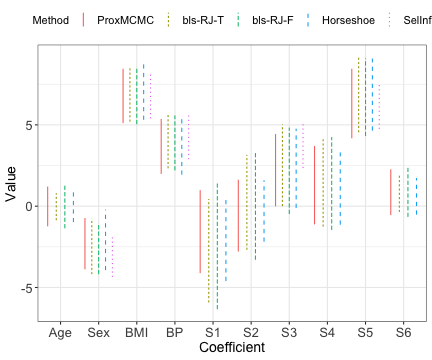

RObject{VecSxp}


In [29]:
R"""
# df <- read.csv("blasso-proxmcmc.csv")
dodge <- position_dodge(width=0.9)
ggplot(df, aes(coef)) + 
    geom_linerange(aes(ymin = lower, ymax = upper, color = Method, linetype = Method), position = dodge) + 
    theme_bw() +
    theme(
        legend.position = "top", axis.text=element_text(size=13), axis.title=element_text(size=14), 
        legend.text = element_text(size=11)
    ) + 
    scale_x_discrete(breaks=as.character(1:10), labels=c("Age", "Sex", "BMI", "BP", paste0("S", 1:6))) + 
    labs(x = "Coefficient", y = "Value") 
#ggsave("../plots/plain-lasso.eps", dpi = 300, width = 8, height = 6)
"""